## Análise 1: sentimentos no tempo

precisa ter variancia para ter relevancia

fazer gráficos 

soma, média, médiana, contagem, menor, maior 


In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
from datetime import timedelta

import os
os.chdir('C:\\Users\\Vinim\\Documents\\github\\tcc_vinicius')

In [4]:
def check_sentiment_type(value):
    try:
      value = float(value)
    except:
       value = 0
    return value  

df = pd.read_parquet('result_processing//news_sentiment_v2.parquet')


df['sentiment score'].fillna(0, inplace=True)
df['sentiment score'] = df['sentiment score'].apply(check_sentiment_type)
df['sentiment score'] = df['sentiment score'].astype(int)
df.loc[df['sentiment score'] > 5, 'sentiment score'] = 5 
df.loc[df['sentiment score'] < -5, 'sentiment score'] = -5

In [5]:
# df = pd.read_csv("planilhas//df_sample_march_full_2.csv", index_col=0)
df['datePublished'] = pd.to_datetime(df['datePublished'])

In [7]:
# retirar dados que contenha IBOVESPA
filtro_ibovespa  = df['name'].str.upper().str.contains('IBOVESPA')
# df.loc[filtro_ibovespa, ['name','full_text', 'key', 'relevance']].sample(2).values
df.loc[filtro_ibovespa, 'relevance'] = 0

* baixo número de notícias sem relevancia

In [8]:
df['relevance'].value_counts()

relevance
1.0    3913
0.0     314
Name: count, dtype: int64

In [9]:
# filtragem de notícias classificadas de forma adequada
df = df[df['relevance'] == 1].copy()

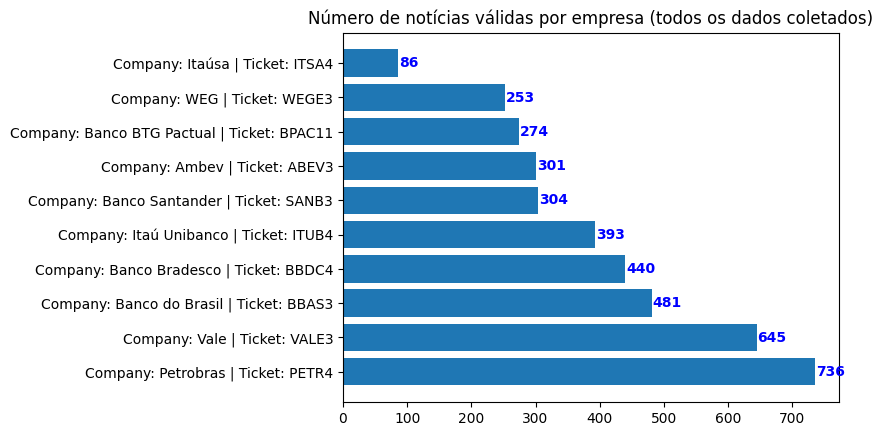

In [10]:
groups = df['key_standard'].value_counts()

fig,ax = plt.subplots()
plt.barh(groups.keys(), groups.values)



for i, v in enumerate(groups.values):
    plt.text(v + 0.9, i, str(v), color='blue', fontweight='bold', verticalalignment='center')

plt.title('Número de notícias válidas por empresa (todos os dados coletados)')
plt.show()

* seleção de uma empresa

In [11]:
df['datePublished'] = df['datePublished'].dt.date

* divisão de sentimentos positivos e negativos

In [12]:
# remoção dos valores de sentimentos que não foi retornado como número
df['sentiment score'] = pd.to_numeric(df['sentiment score'], errors='coerce')
df = df[df['sentiment score'].notna()].copy()

In [13]:
# positivo
df.loc[df['sentiment score'] > 0, 'sentiment score positive'] = df.loc[df['sentiment score'] > 0, 'sentiment score']
df['sentiment score positive'].fillna(0,inplace=True)

# negativo
df.loc[df['sentiment score'] < 0, 'sentiment score negative'] = df.loc[df['sentiment score'] < 0, 'sentiment score']
df['sentiment score negative'].fillna(0,inplace=True)


In [14]:
grouped = df.groupby(['datePublished','key_standard']).agg({'sentiment score':['count', 'mean', 'sum','median', 'max', 'min'],
                                                            'sentiment score positive': 'sum',
                                                             'sentiment score negative': 'sum' })
grouped.reset_index(inplace=True)
grouped = grouped.droplevel(0, axis=1)
grouped.columns = ['date', 'company', 'count', 'mean', 'sum','median', 'max', 'min','positive','negative']
grouped2 = grouped.copy()

In [15]:
# grouped = grouped[grouped['company'] == 'Ticket: PETR4 - company name: Petrobras']

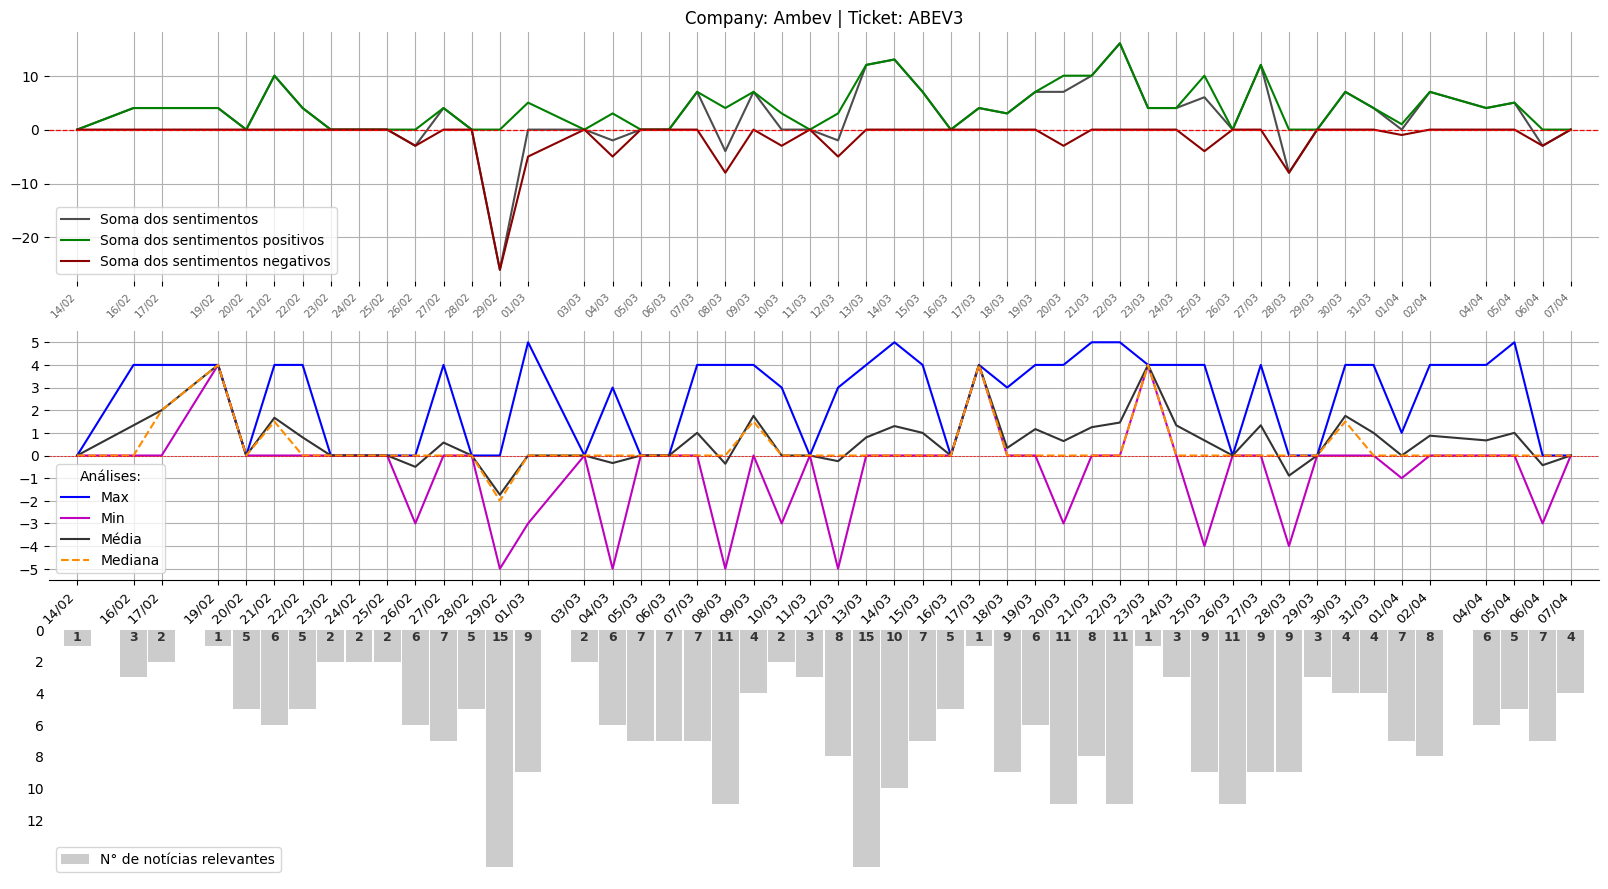

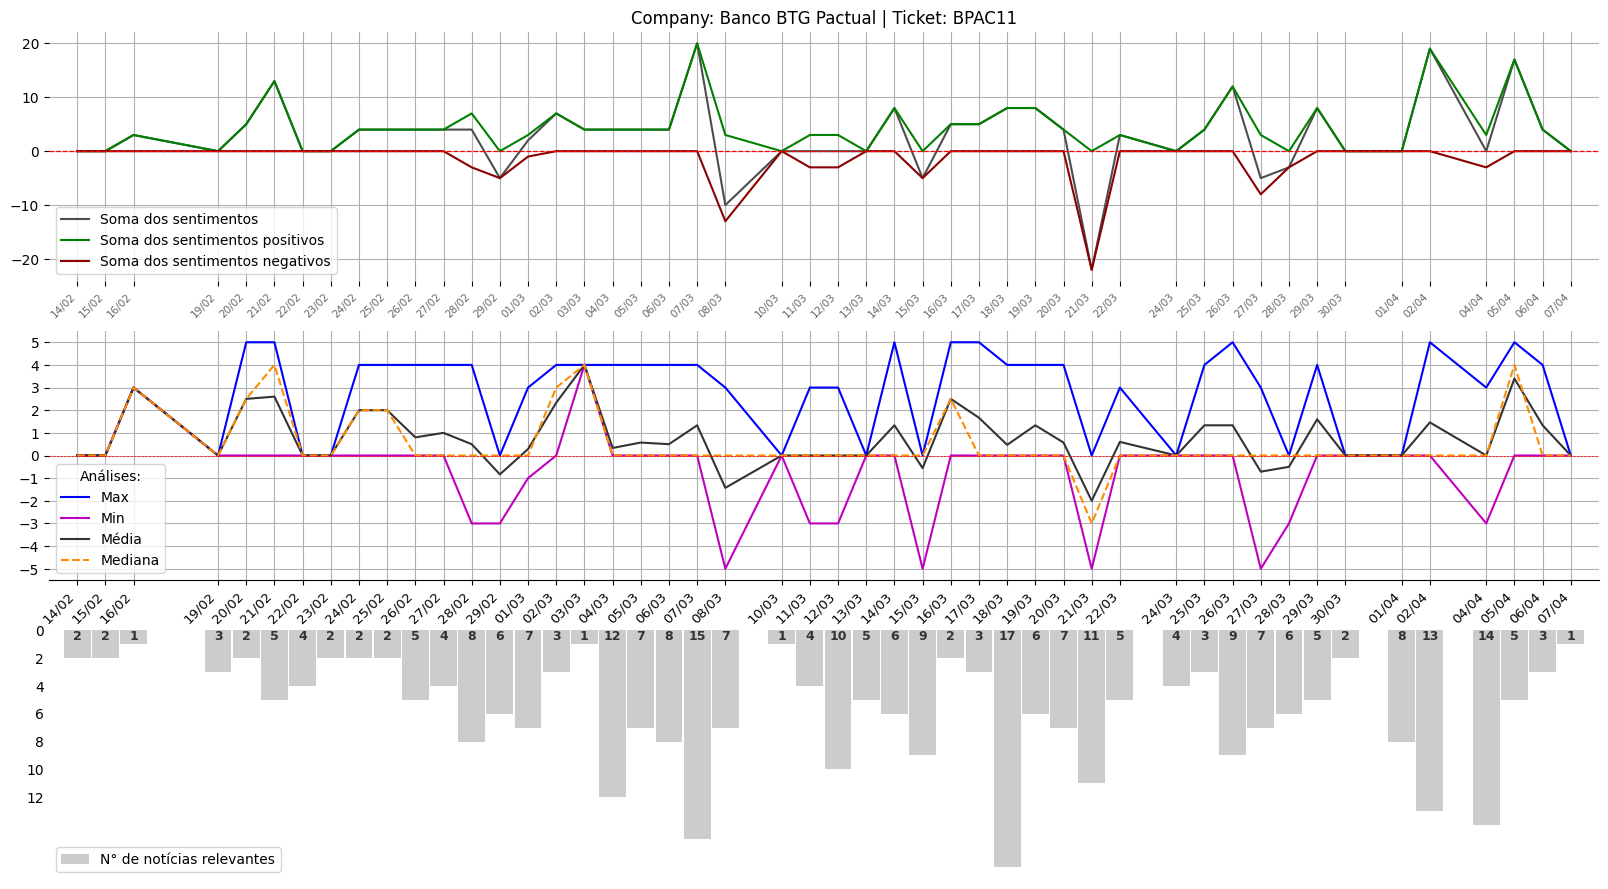

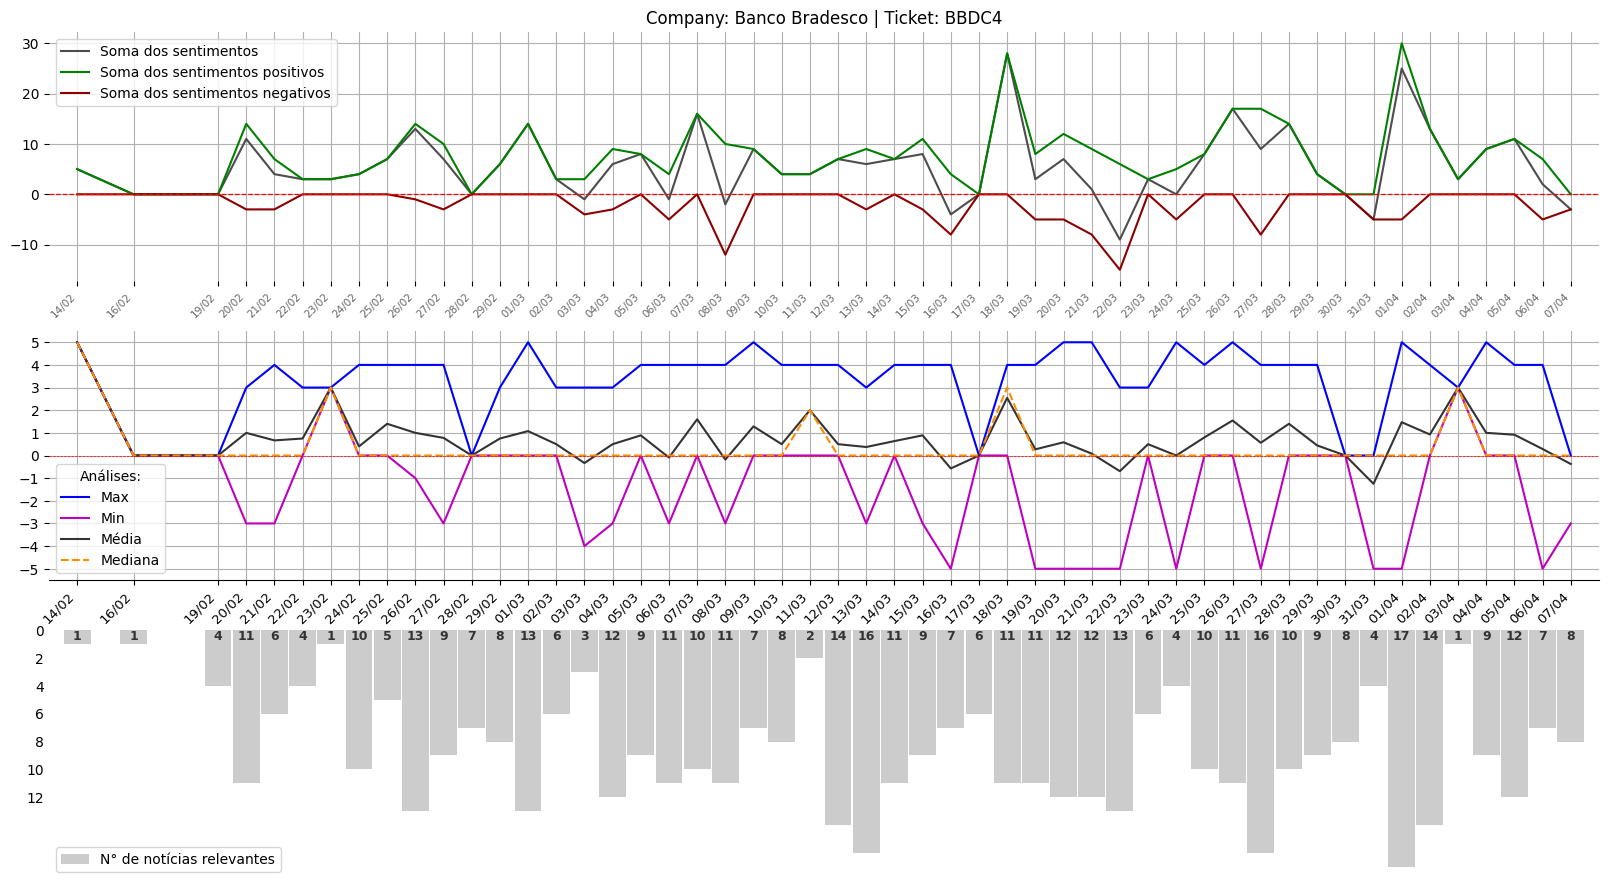

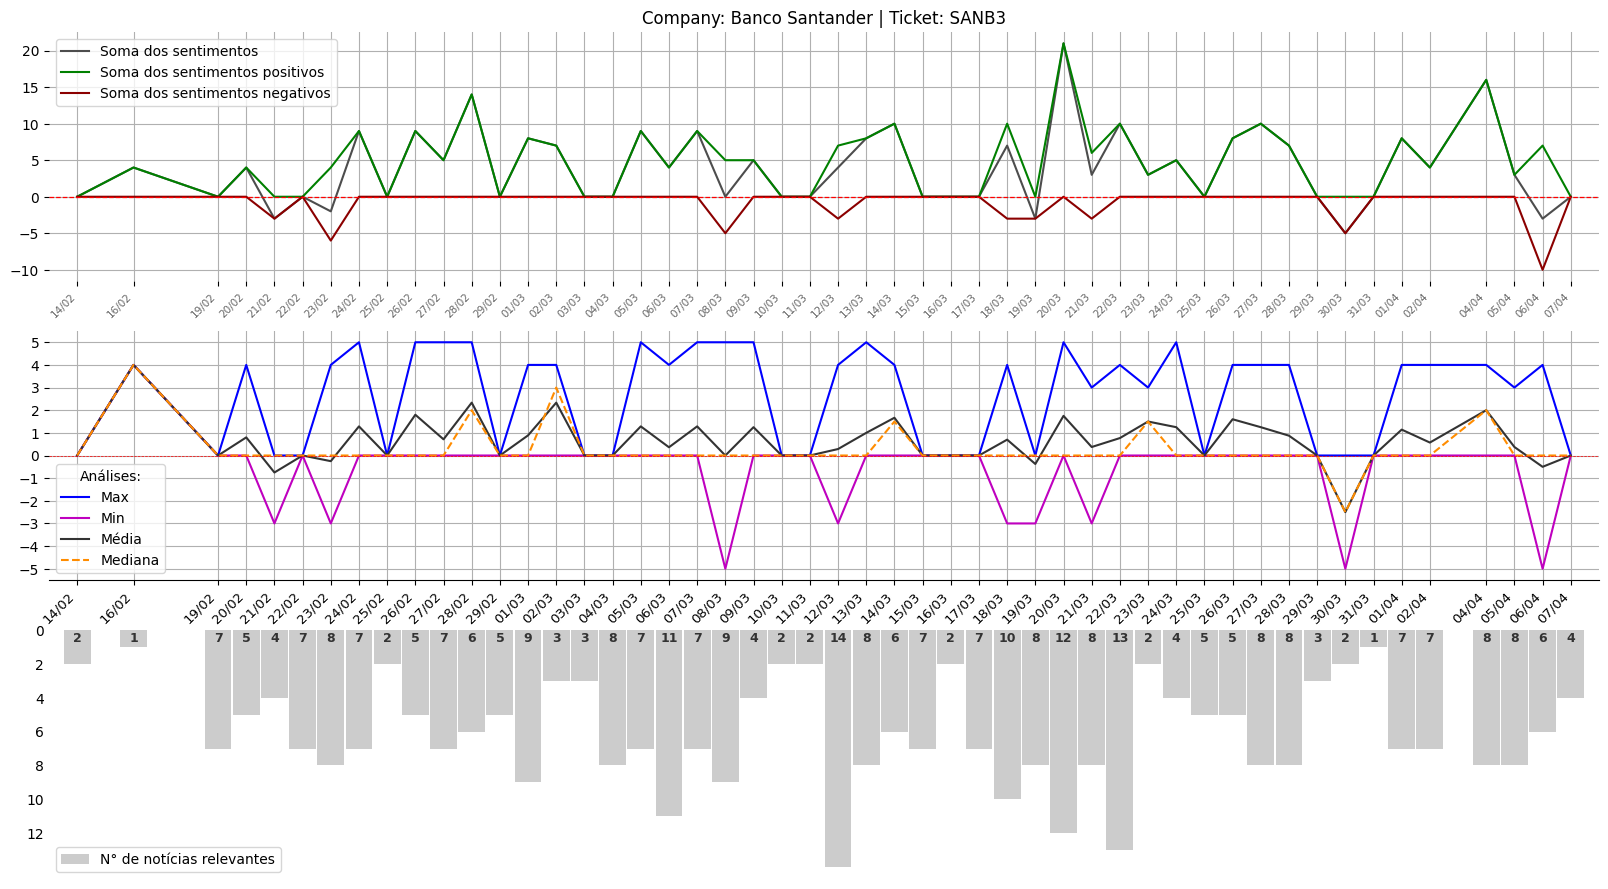

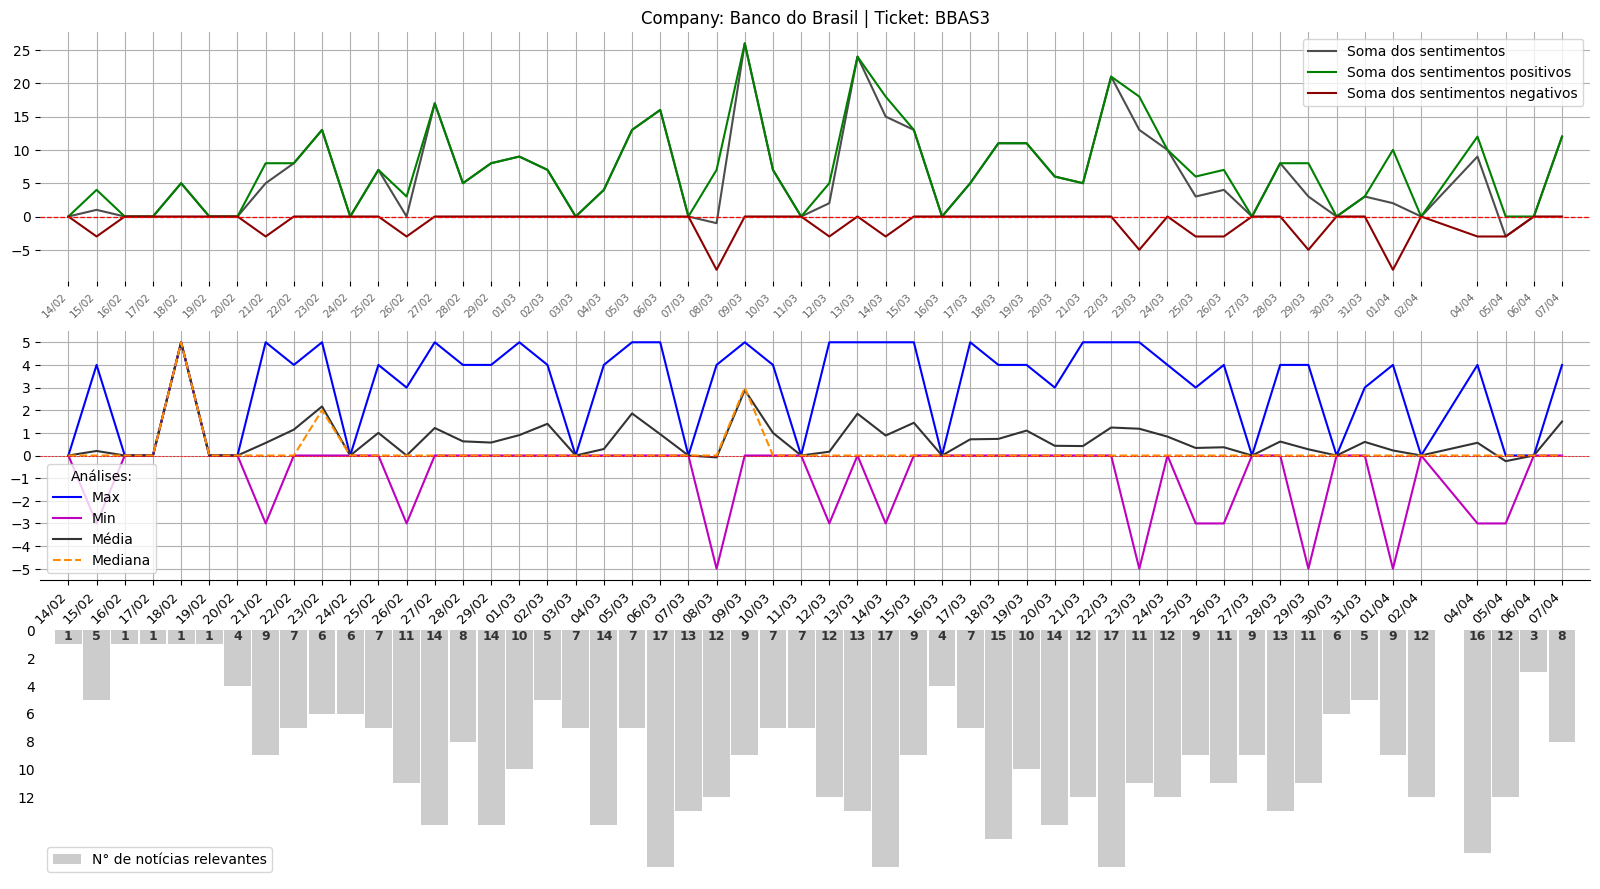

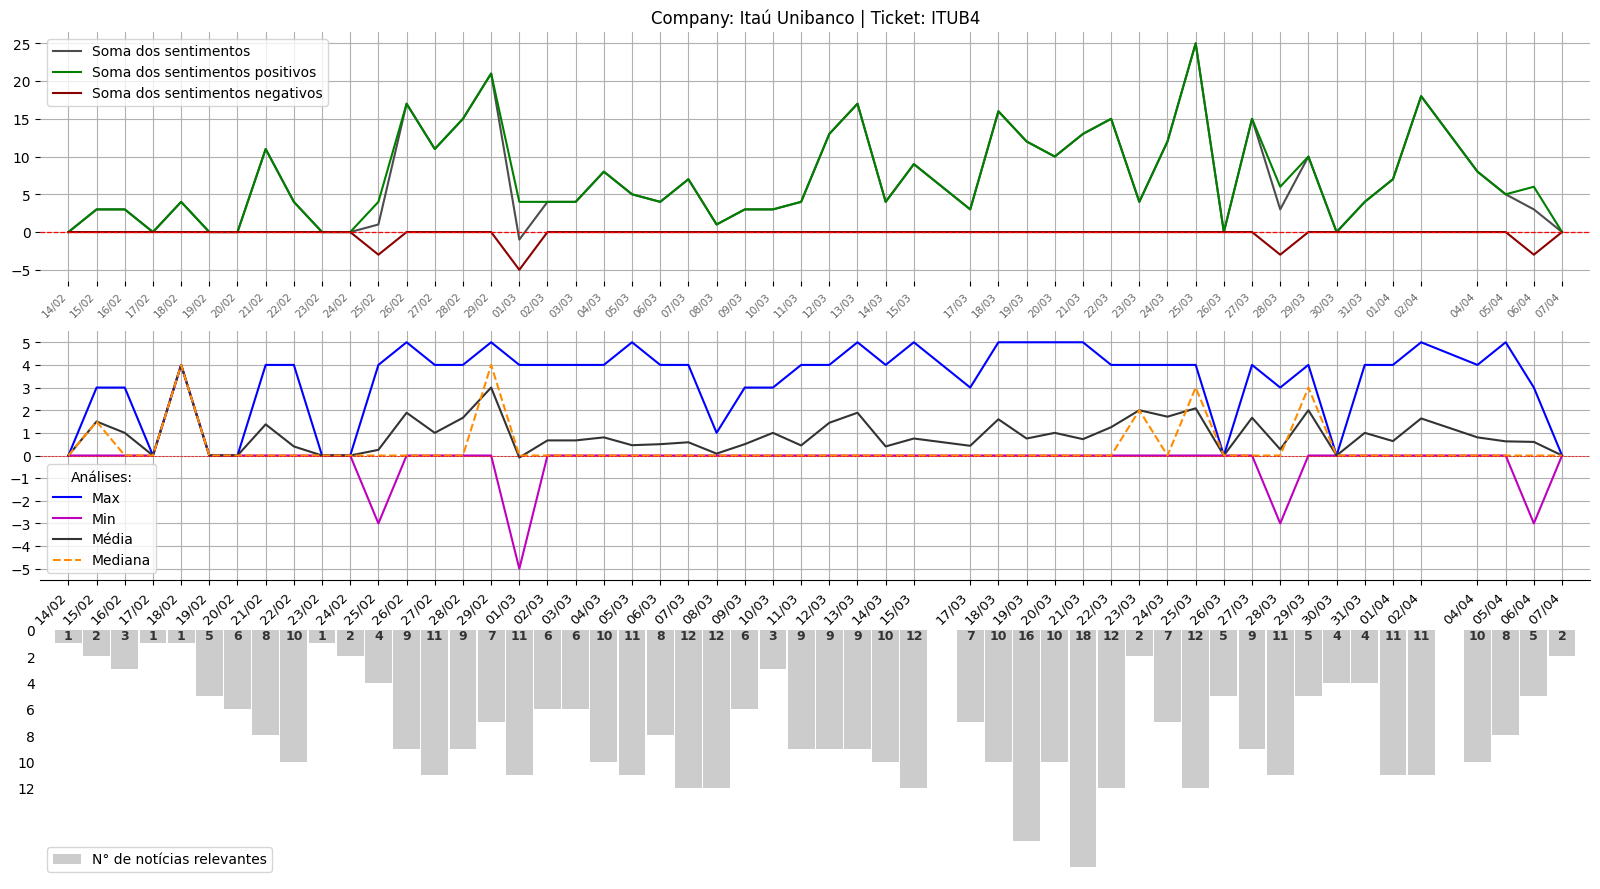

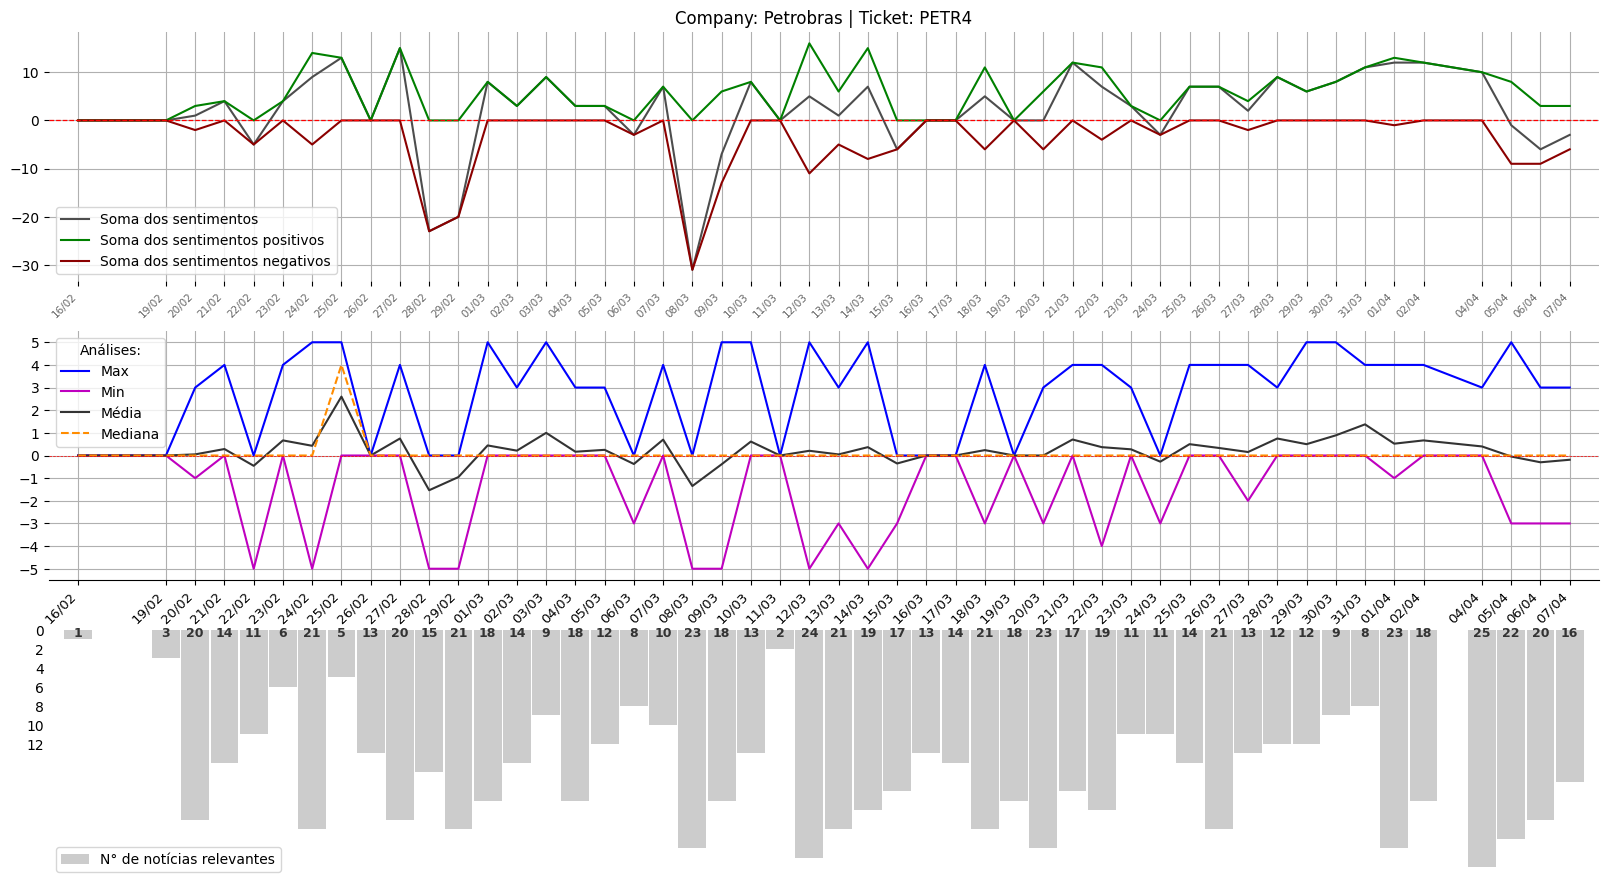

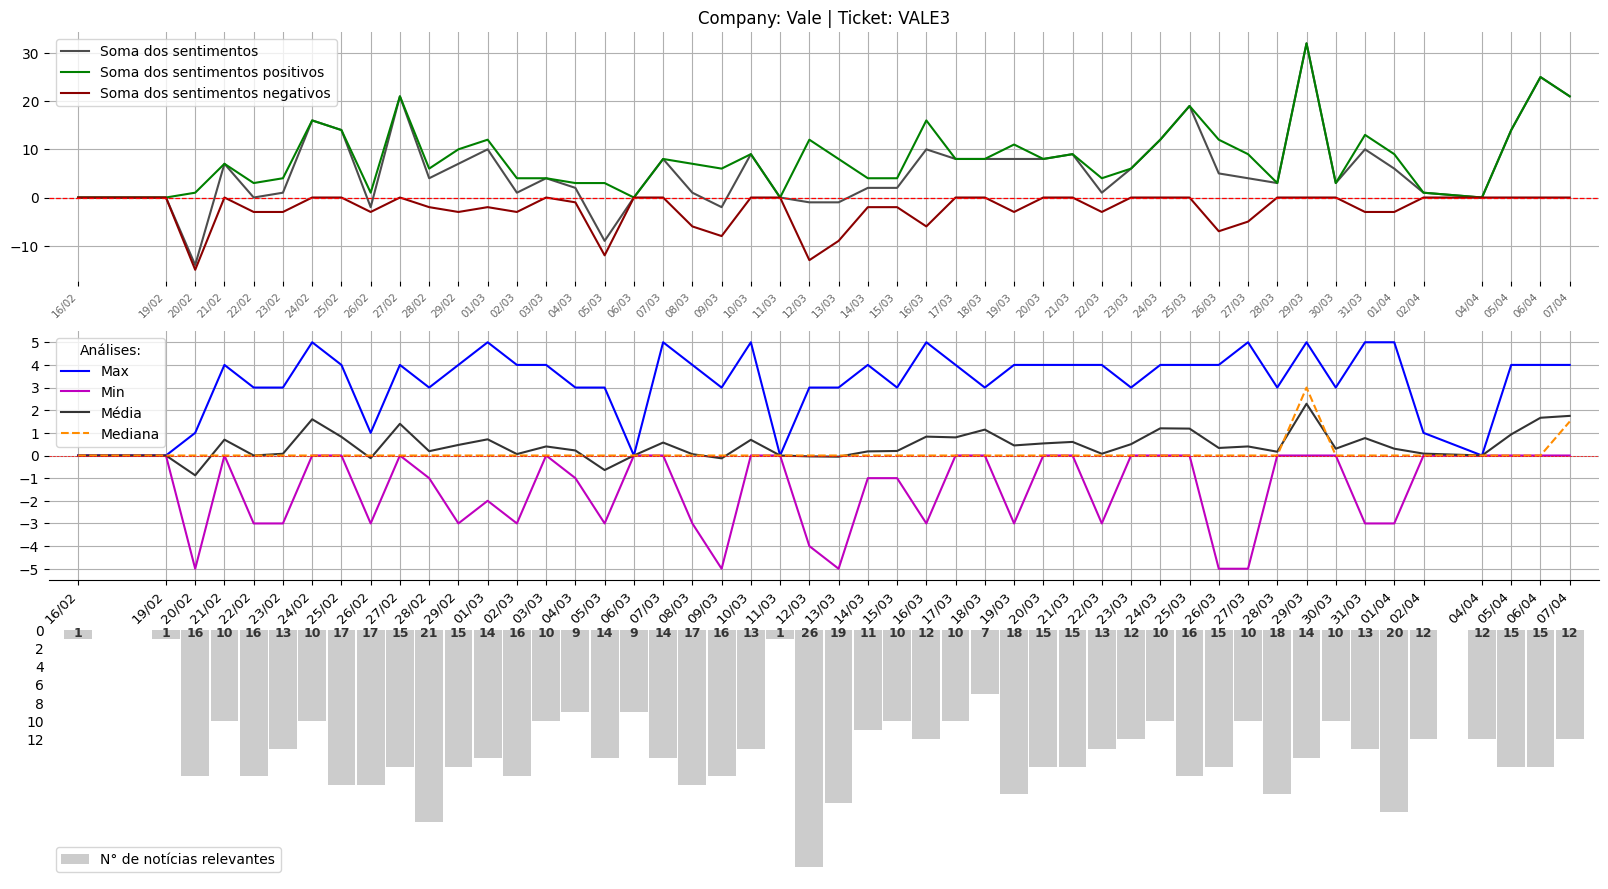

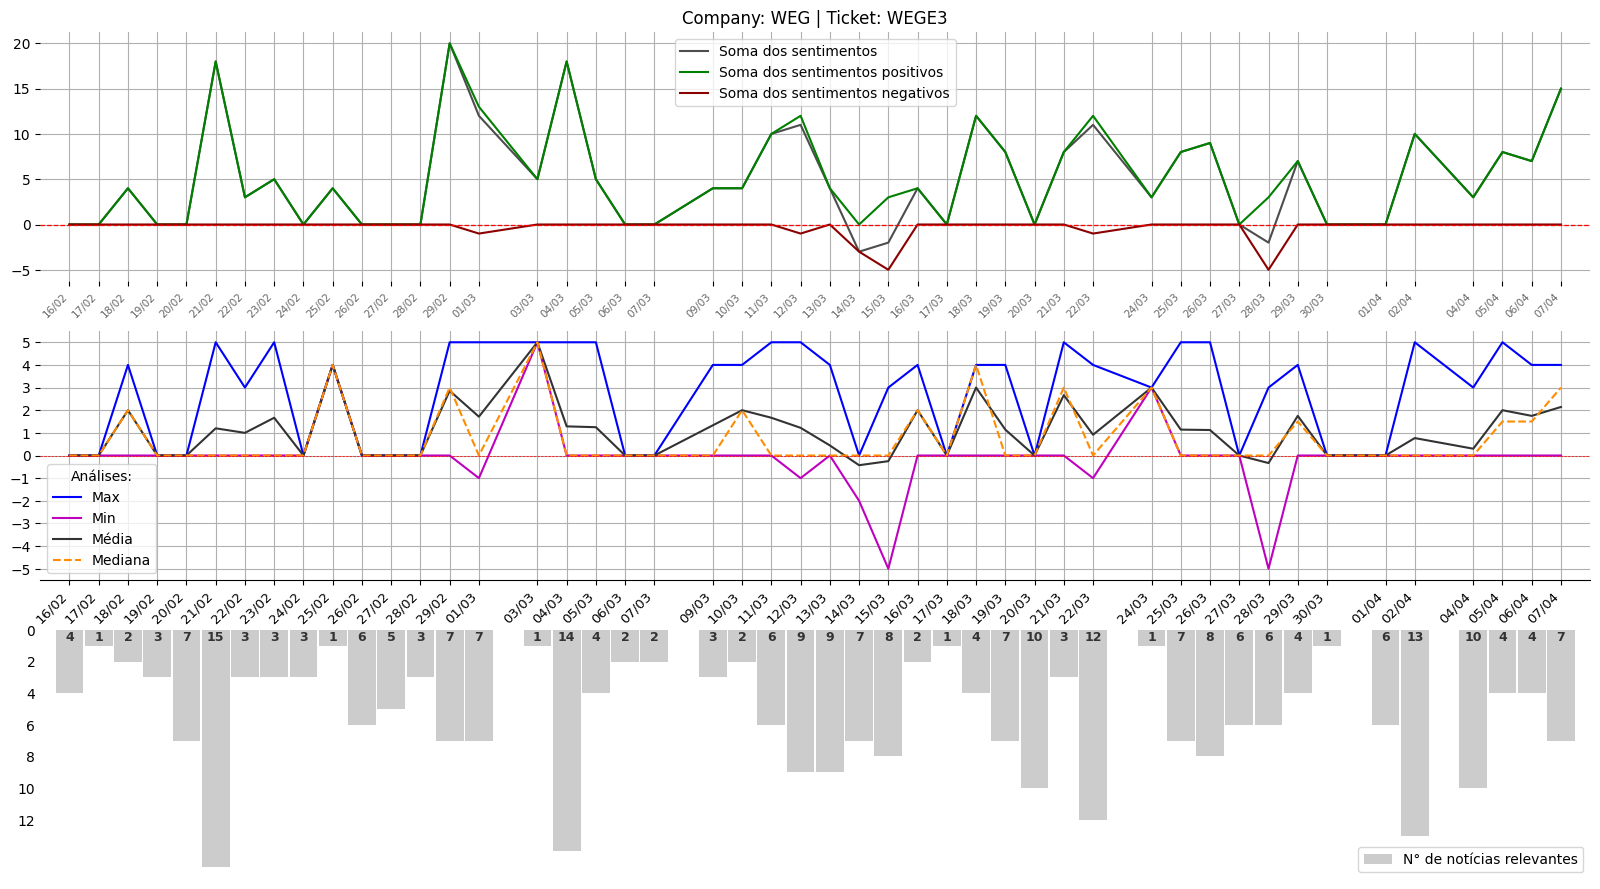

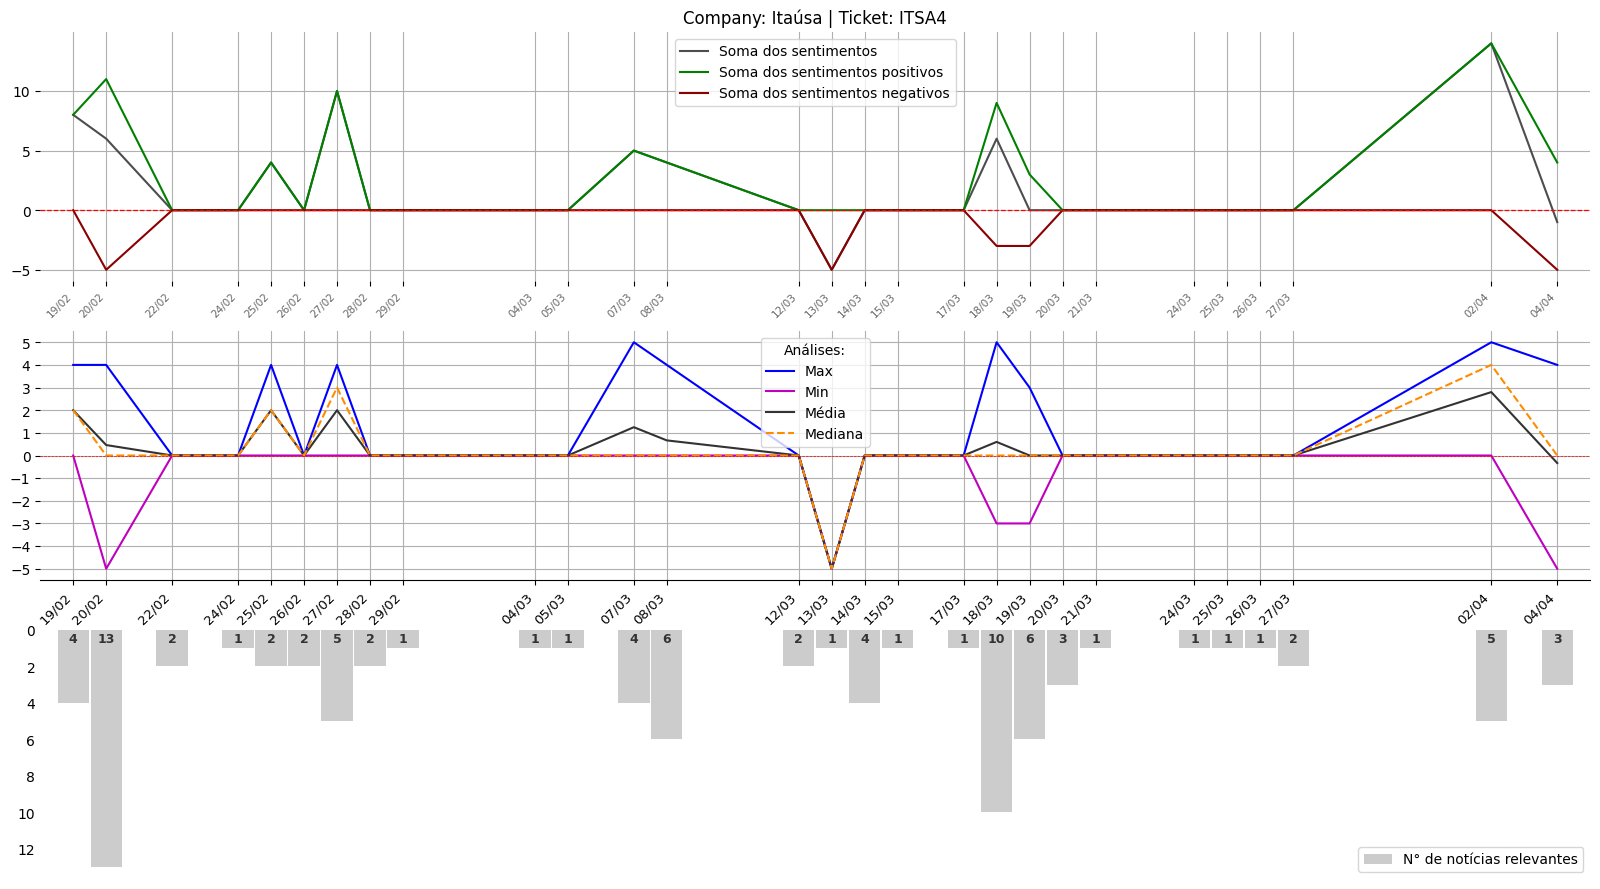

In [16]:
# gráfico    
for company in grouped2['company'].unique():

    grouped = grouped2[grouped2['company'] == company].copy()

    fig,axes = plt.subplots(3,1,figsize=(20, 11))

    x = grouped['date']
    x_ajusted = [j.strftime("%d/%m") for j in list(x)]

    color_0 = '0.4'
    
    axes[0].plot(x,grouped['sum'], color='0.3', label='Soma dos sentimentos')
    axes[0].plot(x,grouped['positive'], color='g', label='Soma dos sentimentos positivos')
    axes[0].plot(x,grouped['negative'], color='darkred', label='Soma dos sentimentos negativos')
    

    axes[0].axhline(y=0, color='red', linestyle='--', lw=0.9)

    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels=x_ajusted,rotation=45, ha='right', fontsize=7.5, color=color_0)

    axes[0].grid()
    axes[0].legend(loc='best')
    axes[0].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    # -------------------------------------------------
    # gráfico 1 
    axes[1].plot(x,grouped['max'], color='b', label='Max')
    axes[1].plot(x,grouped['min'], color='m', label='Min')
    axes[1].plot(x,grouped['mean'], color='0.2', label='Média')
    axes[1].plot(x,grouped['median'], color='darkorange',ls='--', label='Mediana')


    axes[1].axhline(y=0, color='red', linestyle='--', lw=0.5)


    axes[1].spines[['right', 'top', 'left']].set_visible(False)

    #eixo y
    intervalo = np.arange(-5, 6, 1)
    axes[1].set_yticks(intervalo)

    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels=x_ajusted,rotation=45, ha='right', fontsize=9.5)

    axes[1].grid()
    axes[1].legend(title='Análises:', loc='best')

    axes[0].set_title(grouped.iloc[0,1])

    # -------------------------------------------------
    # gráfico 2 

    axes[2].bar(x,grouped['count'], color='0.8', width=0.95, label='N° de notícias relevantes')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels='',rotation=45, ha='right', fontsize=9.5)

    axes[2].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    axes[2].invert_yaxis()
    axes[2].xaxis.set_tick_params(length=0)
    axes[2].yaxis.set_tick_params(length=0)

    intervalo = np.arange(0, 13, 2)
    axes[2].set_yticks(intervalo)

    axes[2].legend(title='', loc='best')

    for index, row in grouped.iterrows():
        axes[2].annotate(str(row['count']),(row['date'], 0.7), ha='center', fontsize=9, fontweight='bold', color='0.2')



    # Definindo os limites dos eixos x para serem os mesmos em ambos os gráficos
    limite_min = min(x) - timedelta(days=1)
    limite_max = max(x) + timedelta(days=1)

    axes[0].set_xlim(limite_min, limite_max)
    axes[1].set_xlim(limite_min, limite_max)
    axes[2].set_xlim(limite_min, limite_max)

    # plt.savefig(f'imagens//analise_sentimentos_março//result_{grouped.iloc[0,1].split(':')[-1].strip()}.png')

    plt.show()

------------------------

## Criação de classe para análisar as ações

In [17]:
from data_processing.y_finance import Stocks
import datetime

In [18]:

# petro = Stocks('PETR4')

# start_date = '2024-02-01'
# end_date = date.today()
# petro.get_price_historic(start_date, end_date)

In [19]:
# fig, ax = plt.subplots()
# petro.plot_price(ax)

# ax.legend()
# plt.show()

In [20]:
# fig, ax = plt.subplots()
# petro.plot_pct_change(ax)

# ax.legend()
# plt.show()

----------------

* observação: alguns tickets não tem histórico no yahoo finance?

In [25]:
grouped

,date,company,count,mean,sum,median,max,min,positive,negative
31,2024-02-19,Company: Itaúsa | Ticket: ITSA4,4,2.000000,8,2.0,4,0,8.0,0.0
41,2024-02-20,Company: Itaúsa | Ticket: ITSA4,13,0.461538,6,0.0,4,-5,11.0,-5.0
60,2024-02-22,Company: Itaúsa | Ticket: ITSA4,2,0.000000,0,0.0,0,0,0.0,0.0
79,2024-02-24,Company: Itaúsa | Ticket: ITSA4,1,0.000000,0,0.0,0,0,0.0,0.0
89,2024-02-25,Company: Itaúsa | Ticket: ITSA4,2,2.000000,4,2.0,4,0,4.0,0.0
99,2024-02-26,Company: Itaúsa | Ticket: ITSA4,2,0.000000,0,0.0,0,0,0.0,0.0
109,2024-02-27,Company: Itaúsa | Ticket: ITSA4,5,2.000000,10,3.0,4,0,10.0,0.0
119,2024-02-28,Company: Itaúsa | Ticket: ITSA4,2,0.000000,0,0.0,0,0,0.0,0.0
129,2024-02-29,Company: Itaúsa | Ticket: ITSA4,1,0.000000,0,0.0,0,0,0.0,0.0
164,2024-03-04,Company: Itaúsa | Ticket: ITSA4,1,0.000000,0,0.0,0,0,0.0,0.0


'ITSA4'

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BEV3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: Ambev | Ticket: ABEV3


[*********************100%%**********************]  2 of 2 completed

2 Failed downloads:
['TIC.SA', '|']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: 'tuple' object has no attribute 'lower'
erros: Company: Banco BTG Pactual | Ticket: BPAC11


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TICKET.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: Banco Bradesco | Ticket: BBDC4


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TICKE.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['TICKE.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: Banco Santander | Ticket: SANB3
Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: Banco do Brasil | Ticket: BBAS3


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ICKET:.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: Itaú Unibanco | Ticket: ITUB4


[*********************100%%**********************]  2 of 2 completed

2 Failed downloads:
['T:', 'PET.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: 'tuple' object has no attribute 'lower'
erros: Company: Petrobras | Ticket: PETR4


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['LE3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: Vale | Ticket: VALE3


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['E3.SA']: Exception('%ticker%: No timezone found, symbol may be delisted')


Error fetching stock data: attempt to get argmax of an empty sequence
erros: Company: WEG | Ticket: WEGE3


[*********************100%%**********************]  1 of 1 completed


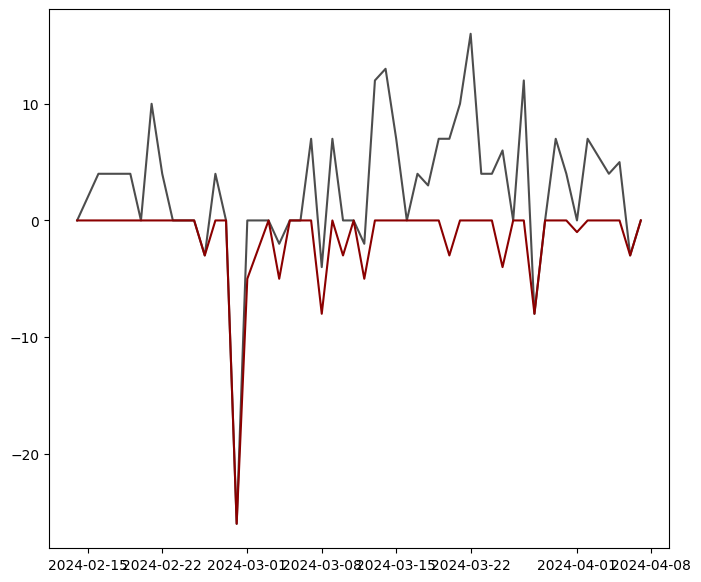

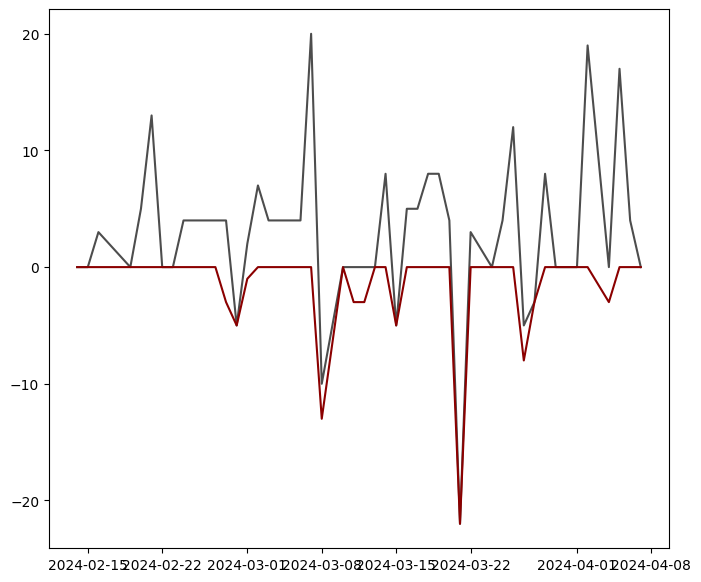

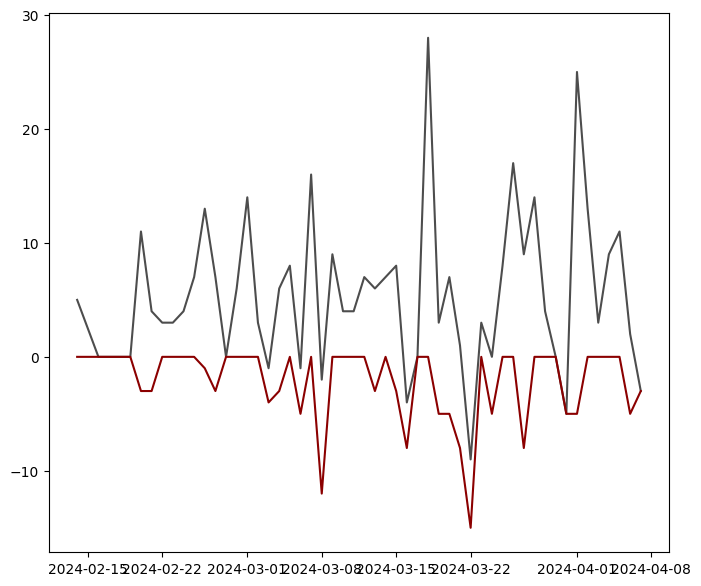

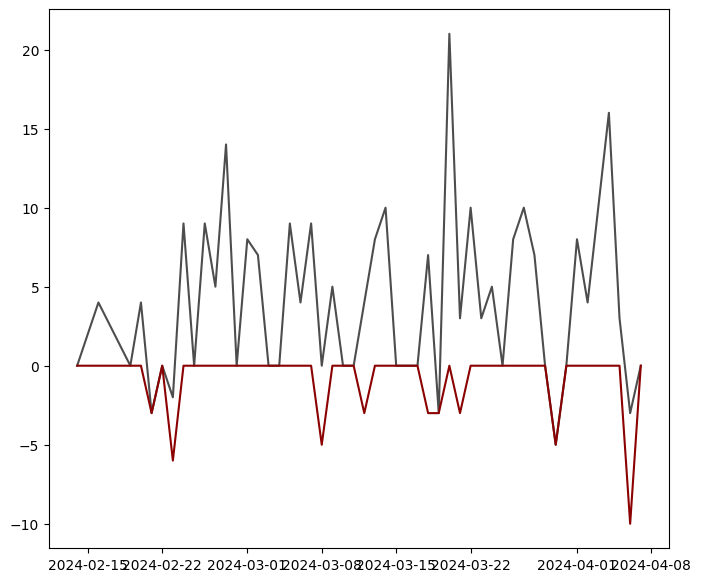

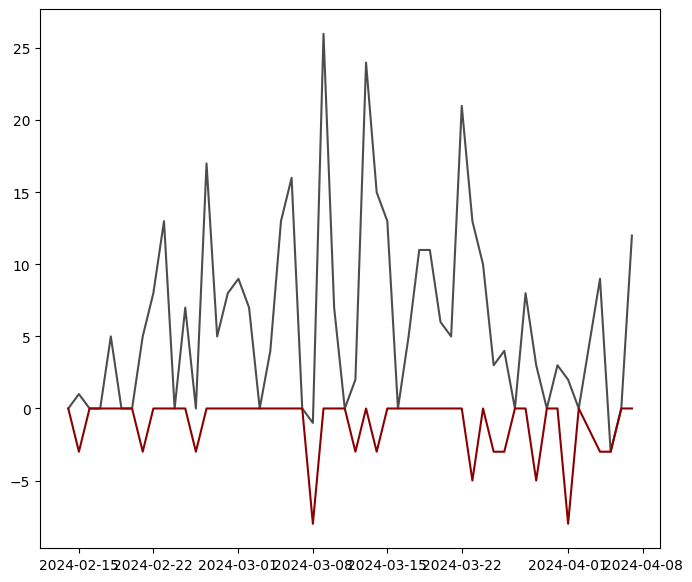

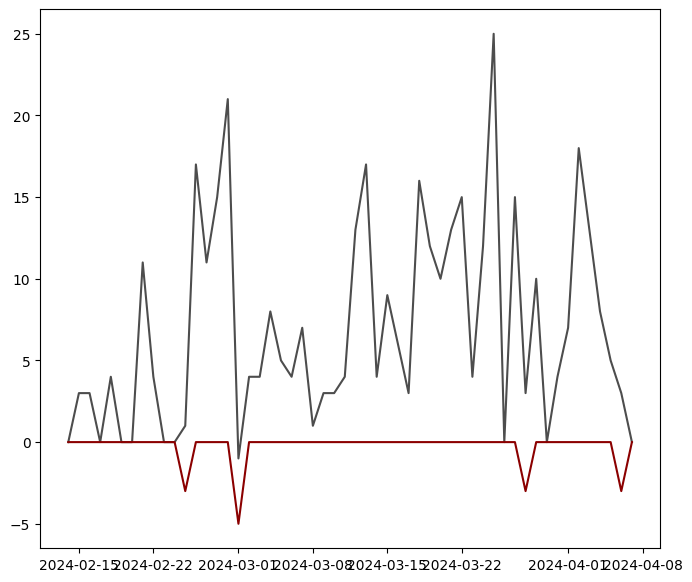

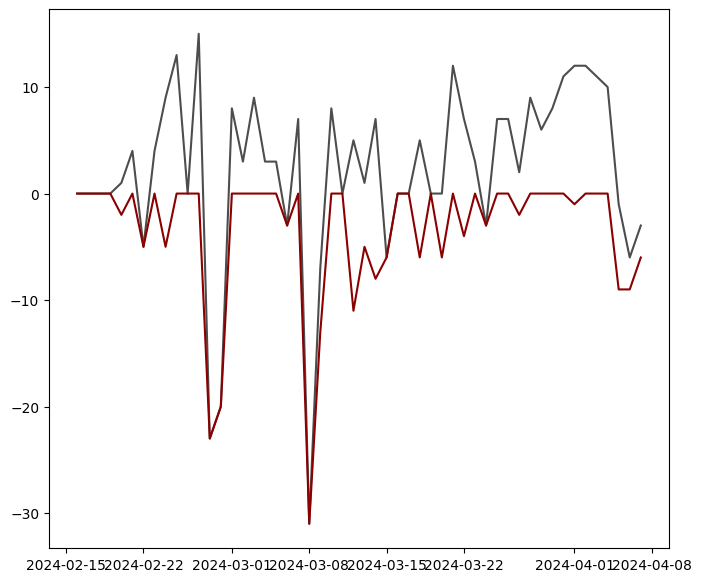

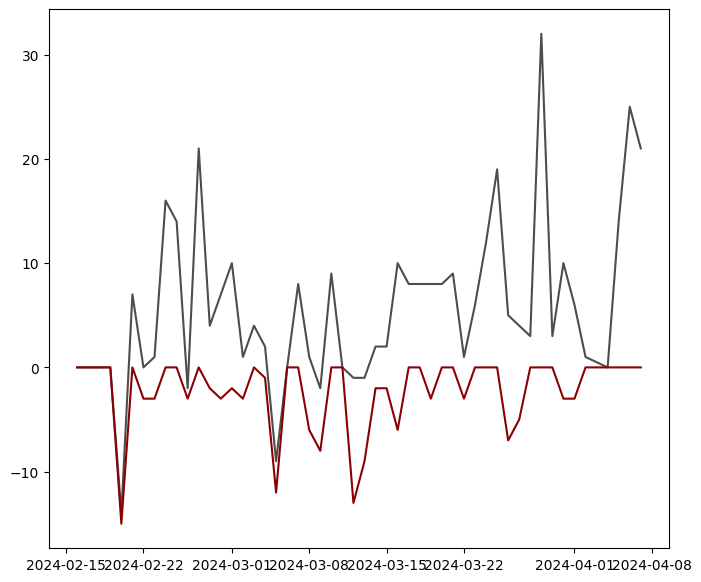

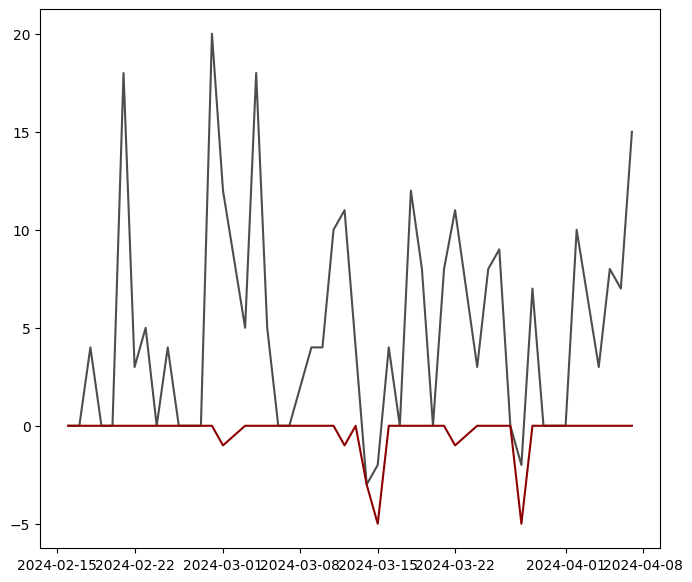

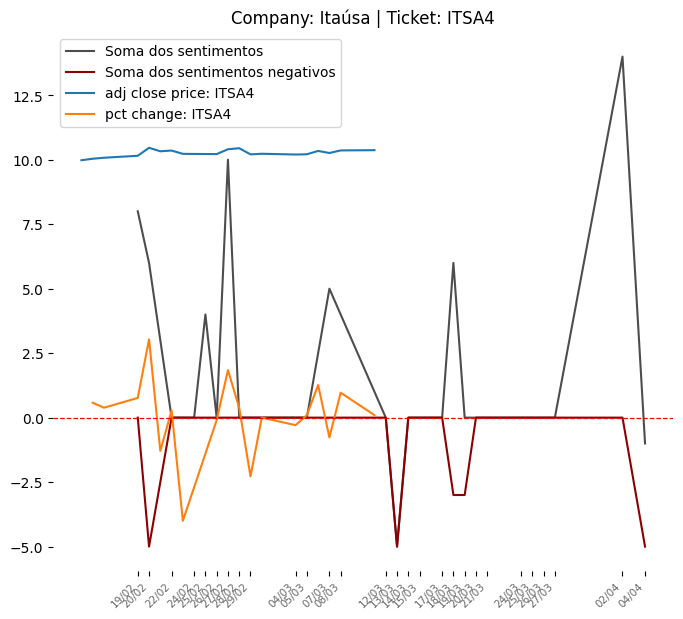

In [43]:
for company in grouped2['company'].unique():
    
# company = 'Ticket: ABEV3 - company name: Ambev'
    grouped = grouped2[grouped2['company'] == company].copy()
    try:
        fig, ax = plt.subplots(figsize= (8,7))    
        x = grouped['date']
        x_ajusted = [j.strftime("%d/%m") for j in list(x)]

        color_0 = '0.4'

        ax.plot(x,grouped['sum'], color='0.3', label='Soma dos sentimentos')
        # ax.plot(x,grouped['positive'], color='g', label='Soma dos sentimentos positivos')
        ax.plot(x,grouped['negative'], color='darkred', label='Soma dos sentimentos negativos')
        

        # arrumar isso!!
        nm = company[26:32]
        if nm == 'BPAC1':
            nm = 'BPAC11'
        
        comp = Stocks(nm)
        

        start_date = '2024-02-10'
        end_date = '2024-03-12' # date.today ()
        comp.get_price_historic(start_date, end_date)
        comp.plot_price(ax)
        comp.plot_pct_change(ax)
        ax.legend(title='', loc='best')


        ax.axhline(y=0, color='red', linestyle='--', lw=0.9)

        # date_range = [start_date + datetime.timedelta(days=x) for x in range((end_date - start_date).days)+1]
        ax.set_xticks(x)
        ax.set_xticklabels(labels=x_ajusted,rotation=45, ha='right', fontsize=7.5, color=color_0)

        # ax.grid()
        ax.legend(loc='best')
        ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)


        ax.set_title(grouped.iloc[0,1])
        
    except:
        print(f'erros: {company}')



In [22]:
from datetime import datetime

In [23]:
filter = (df['key_standard'] == company) & (pd.to_datetime(df['datePublished']) == datetime.strptime('2024-02-27', '%Y-%m-%d'))

In [24]:
# df[filter]['descriptions'].values